In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  # default is ‘last_expr’

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/data/home/marmot/camtrap/PyCharm/CameraTraps-benchmark')
#sys.path.append('/Users/siyuyang/Source/Repos/GitHub_MSFT/CameraTraps-benchmark')

In [3]:
import json
import os

from sklearn.metrics import precision_recall_curve, confusion_matrix

import numpy as np
from benchmark import model_eval_utils
from data_management import cct_json_utils
from api.batch_processing.postprocessing import load_api_results
from visualization.visualization_utils import plot_precision_recall_curve, plot_confusion_matrix

# Evaluate empty non-empty classification on the sequence level

Evaluated on the two validation sets using models trained on the respective training set. The models were detectors on animal/human classes.

The error `TypeError: 'AxesSubplot' object does not support indexing` seems to recover after running again...

In [4]:
def load_json(path):
    with open(path) as f:
        j = json.load(f)
    return j

In [29]:
classes = ['empty', 'non-empty']  # non-empty is class 1, empty is class 0

def evaluate_empty_classification(gt_path, detector_output_path, load_api_res_fn, title='', images_dir=''):
    gt_db_indexed = cct_json_utils.IndexedJsonDb(gt_path)

    model_eval_utils.get_number_empty_seq(gt_db_indexed)

    accuracy, gt_seq_level, pred_seq_level, seq_ids = model_eval_utils.empty_accuracy_seq_level(gt_db_indexed, 
                                                                                       detector_output_path,
                                                                                       load_api_res_fn,
                                                                                        threshold=0.5)
    print('Accuracy by using 0.5 as confidence threshold:', accuracy)

    accuracy, gt_seq_level, pred_seq_level, seq_ids = model_eval_utils.empty_accuracy_seq_level(gt_db_indexed, 
                                                                                       detector_output_path,
                                                                                       load_api_res_fn,
                                                                                        threshold=0.99)
    print('Accuracy by using 0.99 as confidence threshold:', accuracy)

    precisions, recalls, thresholds = precision_recall_curve(gt_seq_level, pred_seq_level)

    p = plot_precision_recall_curve(precisions, recalls, title=title)

    prec_at_recall, th = model_eval_utils.find_precision_at_recall(precisions, recalls, thresholds, recall_level=0.9)
    print('Precision at 0.9 recall is {}, at threshold {}'.format(prec_at_recall, th))
    
    # use the confidence threshold that produced recall = 0.9 to plot a confusion matrix
    accuracy, gt_seq_level, pred_seq_level, seq_ids = model_eval_utils.empty_accuracy_seq_level(gt_db_indexed, 
                                                                detector_output_path,
                                                                load_api_res_fn,
                                                                threshold=th,
                                                                visualize_wrongly_classified=True,
                                                                images_dir=images_dir)
    print('Accuracy at threshold {} is {}'.format(th, accuracy))
    pred_class = [0 if max_conf < th else 1 for max_conf in pred_seq_level]
    cm = confusion_matrix(gt_seq_level, pred_class)
    p = plot_confusion_matrix(cm, classes, title=title)

## SS Season 1

In [6]:
ss_images_dir = '/home/marmot/camtrap/mnt/snapshot-serengeti-v2'  # need to be mounted

### On validation set

threshold | accuracy
0.5 | 0.8602
0.9 | 0.8860
0.95 | 0.8926
0.98 | 0.9018
0.99 | 0.9078

There are 34819 sequences, 27735 are empty, which is 79.65478617995922%
Number of sequences not in both gt and pred: 0
Accuracy by using 0.5 as confidence threshold: 0.8602199948304087
Number of sequences not in both gt and pred: 0
Accuracy by using 0.99 as confidence threshold: 0.9078376748327063
Precision at 0.9 recall is 0.6903162911611785, at threshold 0.969
Number of sequences not in both gt and pred: 0
Ground truth is False, predicted class is 1, seq_id SER_S1#J12#1#1069.
Ground truth is True, predicted class is 0, seq_id SER_S1#F08#3#879.
Ground truth is True, predicted class is 0, seq_id SER_S1#I05#1#9.
Ground truth is False, predicted class is 1, seq_id SER_S1#J12#1#587.
Ground truth is False, predicted class is 1, seq_id SER_S1#J12#1#1589.
Accuracy at threshold 0.969 is 0.8974697722507826


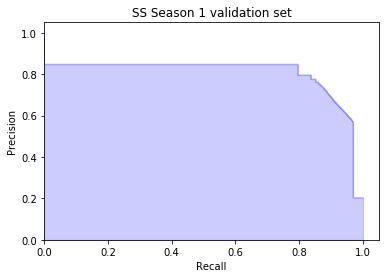

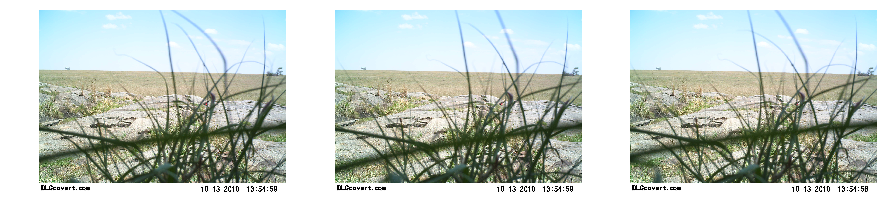

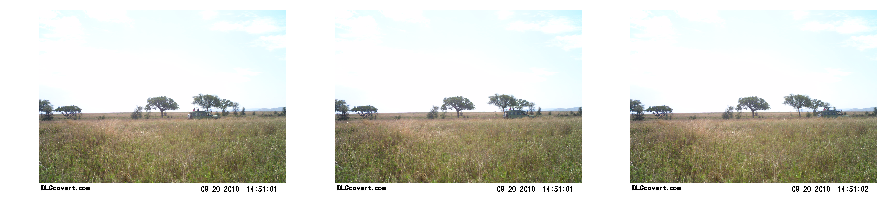

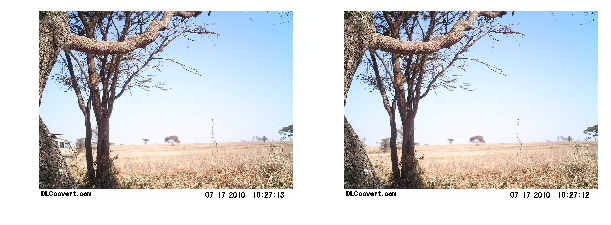

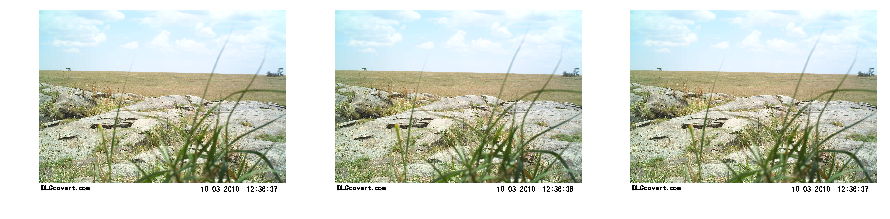

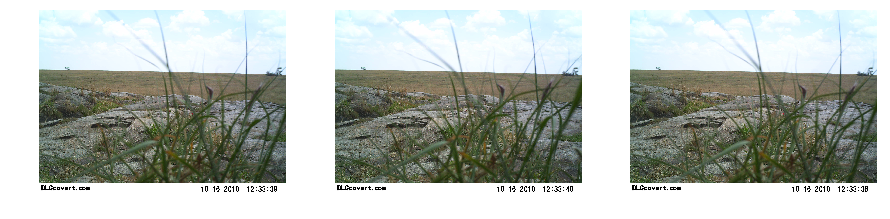

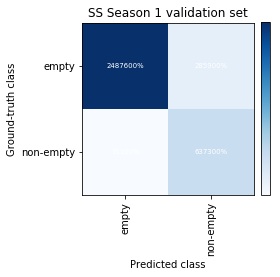

In [26]:
gt_path_ss_val = '/beaver_disk/camtrap/ss_season1/benchmark/ss_season1_images_20190919_val.json'
detector_output_path_ss_val = '/home/marmot/camtrap/mnt/intermediate/dataset_paper/detector_results_one_class/SS_season1/detections_ss_1c_detector_ss_val_all_images.json'

evaluate_empty_classification(gt_path_ss_val, detector_output_path_ss_val, 
                              load_api_results.ss_file_to_file_name, 
                              title='SS Season 1 validation set',
                              images_dir=ss_images_dir)

### On training set

Just to see...

There are 113407 sequences, 94802 are empty, which is 83.59448711278846%
Number of sequences not in both gt and pred: 34
Accuracy by using 0.5 as confidence threshold: 0.8429343847300503
Number of sequences not in both gt and pred: 34
Accuracy by using 0.99 as confidence threshold: 0.9485327194305523
Precision at 0.9 recall is 0.8517422580480588, at threshold 0.996
Number of sequences not in both gt and pred: 34
Ground truth is False, predicted class is 1, seq_id SER_S1#T13#1#1790.
Ground truth is True, predicted class is 0, seq_id SER_S1#R10#2#308.
Ground truth is False, predicted class is 1, seq_id SER_S1#B07#1#121.
Ground truth is False, predicted class is 1, seq_id SER_S1#E08#2#607.
Ground truth is False, predicted class is 1, seq_id SER_S1#I13#1#287.
Accuracy at threshold 0.996 is 0.9575207500904095


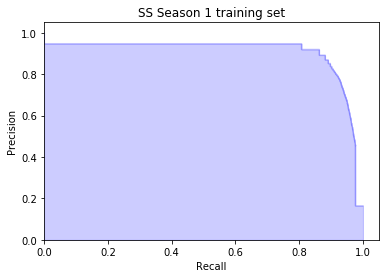

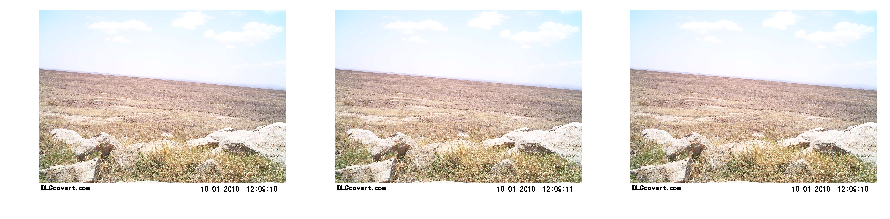

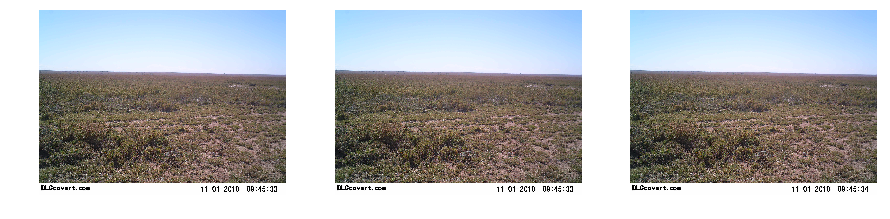

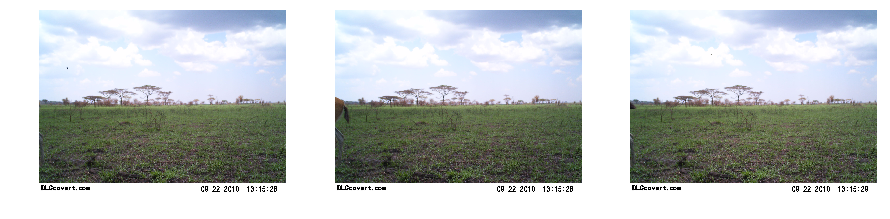

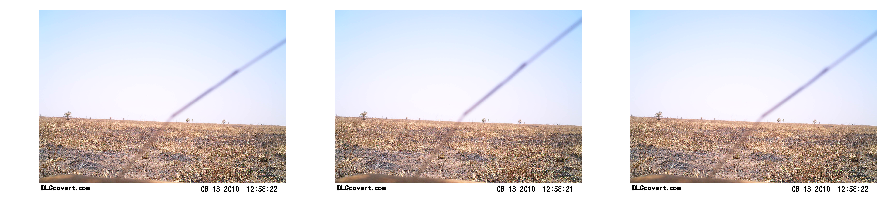

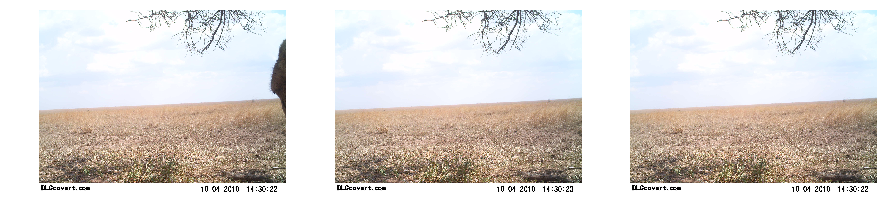

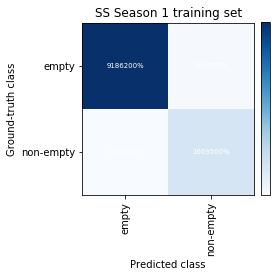

In [23]:
gt_path_ss_train = '/beaver_disk/camtrap/ss_season1/benchmark/ss_season1_images_20190919_train.json'
detector_output_path_ss_train = '/home/marmot/camtrap/mnt/intermediate/dataset_paper/detector_results_one_class/SS_season1/331_detections_ss_1c_detector_ss_train_all_images_20191001001617.json'

evaluate_empty_classification(gt_path_ss_train, detector_output_path_ss_train,
                              load_api_results.ss_file_to_file_name, 
                              title='SS Season 1 training set',
                              images_dir=ss_images_dir)

There is some noise in the sequence level labels. A lot of the false negatives for this dataset are because of cars - the training data had very few boxes of humans and none for cars.

## CCT all images

In [27]:
cct_images_dir = '/beaver_disk/camtrap/caltech'

### On validation set

There are 40603 sequences, 18544 are empty, which is 45.671502105755735%
Number of sequences not in both gt and pred: 0
Accuracy by using 0.5 as confidence threshold: 0.827648203334729
Number of sequences not in both gt and pred: 0
Accuracy by using 0.99 as confidence threshold: 0.858507992020294
Precision at 0.9 recall is 0.8109477124183007, at threshold 0.54
Number of sequences not in both gt and pred: 0
Ground truth is False, predicted class is 1, seq_id 6f17294a-5567-11e8-8999-dca9047ef277.
Ground truth is False, predicted class is 1, seq_id 70048f6e-5567-11e8-b190-dca9047ef277.
Ground truth is False, predicted class is 1, seq_id 6f504823-5567-11e8-b164-dca9047ef277.
Ground truth is False, predicted class is 1, seq_id 70029826-5567-11e8-bdd8-dca9047ef277.
Ground truth is True, predicted class is 0, seq_id 700b8f57-5567-11e8-9a86-dca9047ef277.
Accuracy at threshold 0.54 is 0.8316626850232741


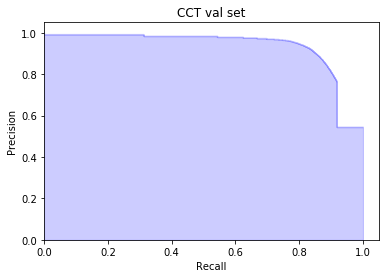

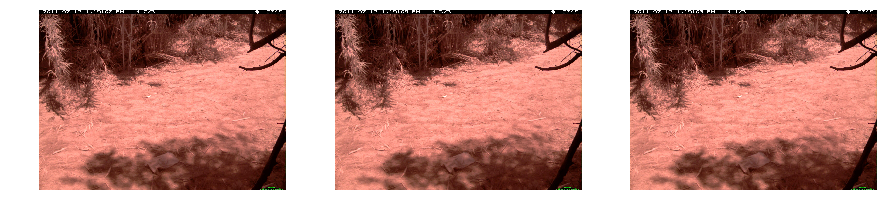

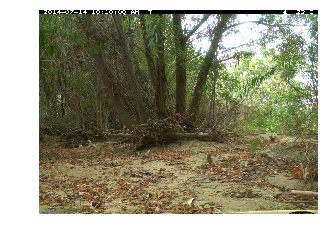

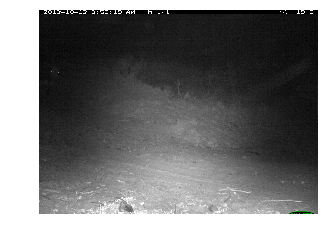

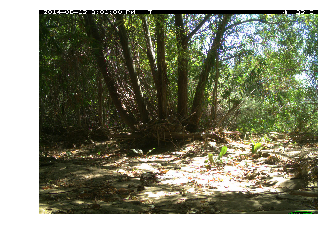

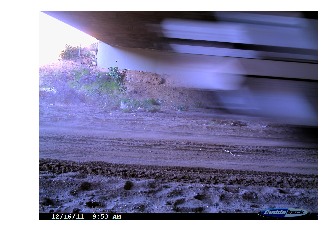

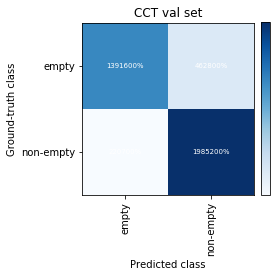

In [31]:
gt_path_cct_val = '/beaver_disk/camtrap/caltech/benchmark/caltech_images_20190919_val.json'
detector_output_path_cct_val = '/home/marmot/camtrap/mnt/intermediate/dataset_paper/detector_results_one_class/CCT/2784_detections_cct_1c_detector_cct_val_all_images_20191001000804.json'

evaluate_empty_classification(gt_path_cct_val, detector_output_path_cct_val,
                              load_api_results.caltech_file_to_file_name, 
                              title='CCT val set',
                              images_dir=cct_images_dir)

### On training set

There are 140405 sequences, 102604 are empty, which is 73.07716961646665%
Number of sequences not in both gt and pred: 0
Accuracy by using 0.5 as confidence threshold: 0.7466471991738186
Number of sequences not in both gt and pred: 0
Accuracy by using 0.99 as confidence threshold: 0.9263274099925216
Precision at 0.9 recall is 0.4560413034732466, at threshold 0.3
Number of sequences not in both gt and pred: 0
Ground truth is False, predicted class is 1, seq_id 6f3cee0a-5567-11e8-a855-dca9047ef277.
Ground truth is False, predicted class is 1, seq_id 6f0a43d7-5567-11e8-bb3a-dca9047ef277.
Ground truth is False, predicted class is 1, seq_id 6fb4cb63-5567-11e8-8e90-dca9047ef277.
Ground truth is False, predicted class is 1, seq_id 6f2473f0-5567-11e8-8e04-dca9047ef277.
Ground truth is False, predicted class is 1, seq_id 6f20d4c0-5567-11e8-999a-dca9047ef277.
Accuracy at threshold 0.3 is 0.6840782023432214


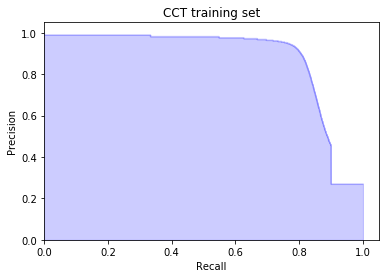

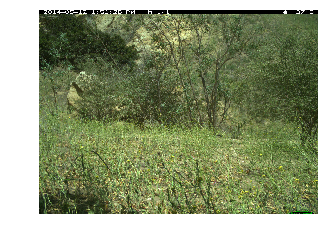

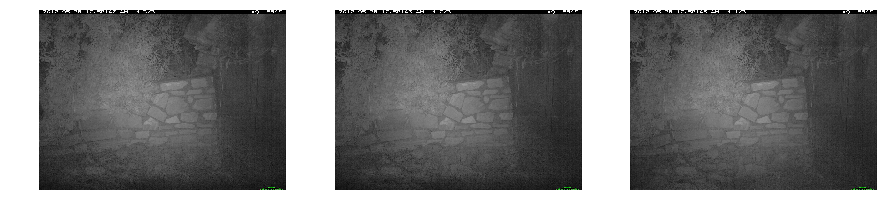

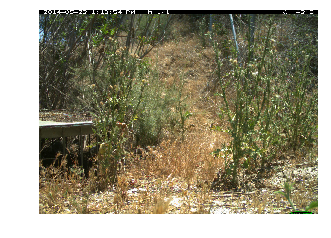

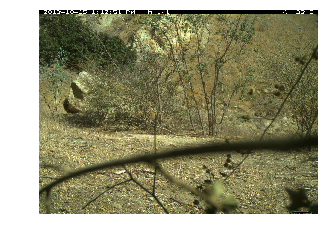

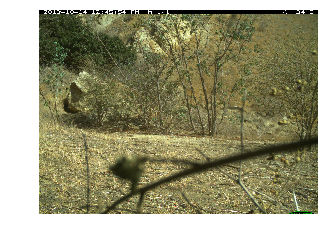

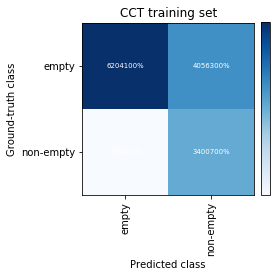

In [34]:
gt_path_cct_val = '/beaver_disk/camtrap/caltech/benchmark/caltech_images_20190919_train.json'
detector_output_path_cct_val = '/home/marmot/camtrap/mnt/intermediate/dataset_paper/detector_results_one_class/CCT/detections_cct_1c_detector_cct_train_all_images.json'

evaluate_empty_classification(gt_path_cct_val, detector_output_path_cct_val,
                              load_api_results.caltech_file_to_file_name, 
                              title='CCT training set',
                              images_dir=cct_images_dir)

For the Caltech Camera Traps dataset, the training set has many more empty images than the validation set.